<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

%matplotlib inline

C:\Users\boco7097\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
titanic = pd.read_csv('../DATA/titanic_train.csv')

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [3]:
# Shape
titanic.shape

(891, 12)

In [4]:
# Head
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Check missing data
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
def facetgridplot(train, var):
    facet = sns.FacetGrid(train, hue="Survived", aspect=4)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, train[var].max()))
    facet.add_legend()
    plt.show();

In [11]:
def bar_chart(train, feature):
    survived = train[train['Survived']==1][feature].value_counts(normalize=True)*100
    dead = train[train['Survived']==0][feature].value_counts(normalize=True)*100
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar', stacked=True, figsize=(10,5))

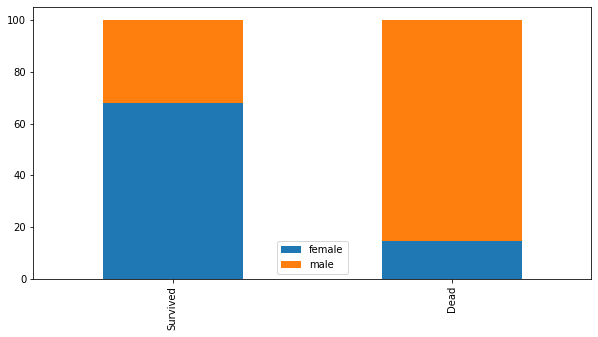

In [12]:
# Sex
bar_chart(titanic, 'Sex')

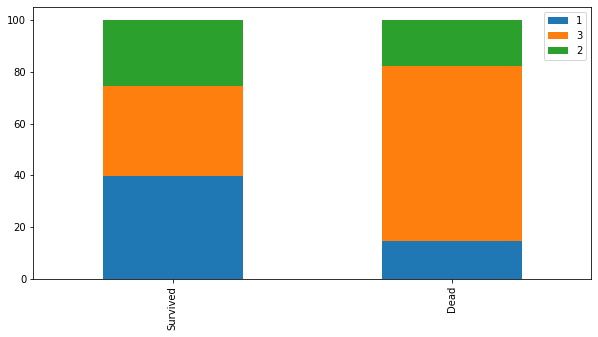

In [13]:
# Pclass
bar_chart(titanic, 'Pclass')

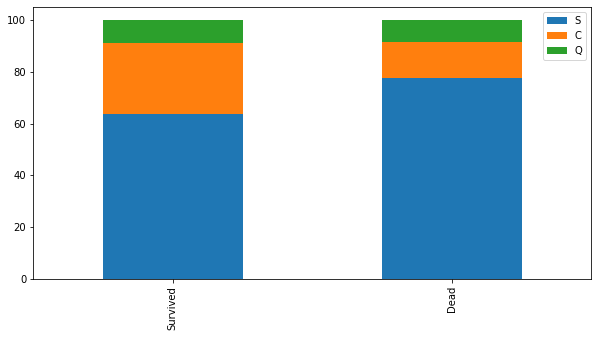

In [14]:
# Embarked
bar_chart(titanic, 'Embarked')

In [16]:
# Find median age by sex
titanic.groupby("Sex")["Age"].median()

Sex
female    27.0
male      29.0
Name: Age, dtype: float64

In [17]:
# array of median age by sex
titanic.groupby("Sex")["Age"].transform("median")

0      29.0
1      27.0
2      27.0
3      27.0
4      29.0
       ... 
886    29.0
887    27.0
888    27.0
889    29.0
890    29.0
Name: Age, Length: 891, dtype: float64

In [20]:
# fill missing age rows with median age for each sex
titanic["Age"].fillna(titanic.groupby("Sex")["Age"].transform("median"), inplace=True)

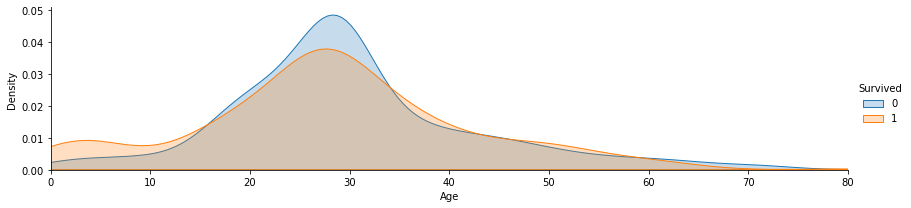

In [21]:
# Age
facetgridplot(titanic, 'Age')

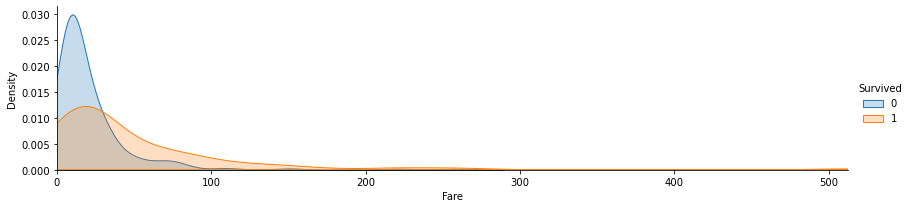

In [22]:
# Fare
facetgridplot(titanic, 'Fare')

In [23]:
# fill missing embarked with 'S' as most people embarked from there
titanic['Embarked'].fillna('S', inplace=True)

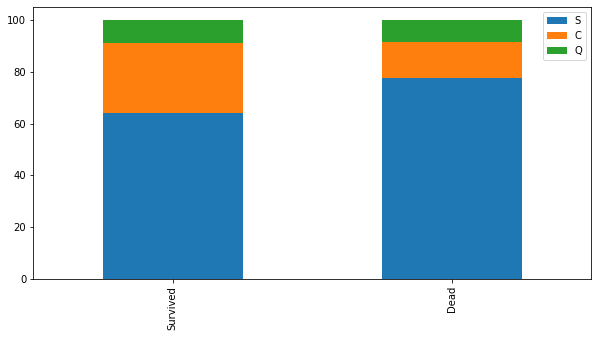

In [24]:
bar_chart(titanic, 'Embarked')

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [25]:
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [26]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [27]:
# Create Model
logreg = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [28]:
# Fit Model
logreg.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [29]:
logreg.coef_

array([[-0.87239066,  0.337888  ]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [30]:
logreg.intercept_

array([1.30430282])

We can create tuples of the predictor names and coefficients like this:

In [32]:
# ANSWER
print(set(zip(feature_cols, logreg.coef_[0])))

{('Pclass', -0.8723906606017785), ('Parch', 0.3378880048779747)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [33]:
for col in zip(X_train.columns, logreg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.872391
Parch       +0.337888


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [34]:
print('accuracy = {:7.4f}'.format(logreg.score(X_train, y_train)))

accuracy =  0.6901


What is the  `accuracy_score` for the test data?

In [36]:
print('accuracy = {:7.4f}'.format(logreg.score(X_test, y_test)))

accuracy =  0.6682


What can we say about this result?

ANSWER
- test set prediction almost as accurate as training set
- overfitting unlikely

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [45]:
titanic['Age'].fillna(titanic.Age.mean(), inplace=True)
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]

In [46]:
# Build Model
logreg = LogisticRegression()

# Fit Model
logreg.fit(X_train, y_train)

# Score
logreg_score = logreg.score(X_train, y_train)
print('accuracy = {:1.4f}'.format(logreg_score))

accuracy = 0.6901


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- Age is not related to survival on Titanic
- Age is not independent of other Pclass and Parch
- Imputing the missing values distorted the distribution too much

Let's see where the model is going wrong by showing the Confusion Matrix:

In [47]:
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[105  23]
 [ 51  44]]


Nb. Here is how `confusion_matrix` arranges its output:

In [48]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: False Negatives.

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

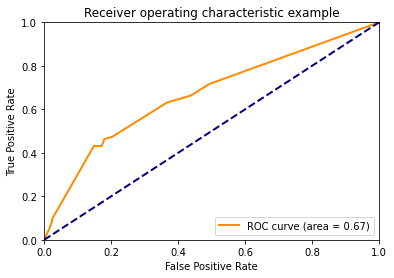

In [49]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [50]:
titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [51]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [54]:
def get_logreg_score(data, feature_cols, target_col):
    X = data[feature_cols]
    y = data[target_col]
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
    
    # Build Model
    logreg = LogisticRegression()
    
    # Fit
    logreg.fit(X_train, y_train)
    
    # Score
    logreg_score = logreg.score(X_test, y_test)
    
    # Predict
    logreg_preds = logreg.predict(X_test)
    
    # Predict probability
    logreg_pred_proba = logreg.predict_proba(X_test)[:,1]
    
    # Return accuracy rate
    return logreg_score, logreg_preds, logreg_pred_proba

In [55]:
# Set features with numerical, categorial
target_col = 'Survived'
feature_cols = ['Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp']
get_logreg_score(titanic_with_dummies, feature_cols, target_col)

(0.6547085201793722,
 array([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0], dtype=int64),
 array([0.50289655, 0.20063421, 0.60123263, 0.21370953, 0.82211524,
        0.25657853, 0.58813252, 0.57038775, 0.63694451, 0.1753124 ,
        0.22739457, 0.22047591, 0.44341993, 0.48321716, 0.21370953,
   

Plot the ROC curve for the new model:

In [57]:
def plot_roc_curve(X_test, y_test):
    # Generate prediction values for each test observation using predict_proba
    preds = logreg.predict_proba(X_test)[:,1]
    
    # Store false positive rate, true positive rate in vectors for use in graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    
    # Store Area Under Curve (AUC) so we can annotate graph with this metric
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()

Can we improve the model by including the remaining features?

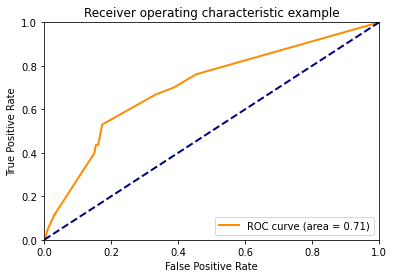

In [58]:
# Train
plot_roc_curve(X_train, y_train)

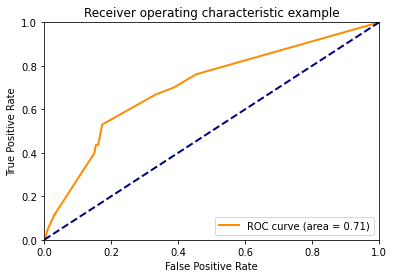

In [59]:
# Test
plot_roc_curve(X_train, y_train)

Can we improve model by including remaining features?


In [60]:
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
                'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1',
                'Pclass_2', 'Pclass_3']
get_logreg_score(titanic_with_dummies, feature_cols, target_col)

C:\Users\boco7097\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.8026905829596412,
 array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0], dtype=int64),
 array([0.82123845, 0.08197175, 0.88631688, 0.65863512, 0.92989654,
        0.11127627, 0.22371101, 0.85022614, 0.5193755 , 0.57146606,
        0.09562768, 0.57271742, 0.21933391, 0.26278644, 0.65849653,
   

In [61]:
ttwd = titanic_with_dummies
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
    100 * ttwd[ttwd.Sex_male == 1].Survived.mean(), ttwd.Sex_male.sum(),
    100 * ttwd[ttwd.Sex_female == 1].Survived.mean(), ttwd.Sex_female.sum(),
    100 * ttwd[ttwd.Age < 16].Survived.mean(), len(ttwd[ttwd.Age < 16])))

Male survival: 18.89% of 577
Female survival: 74.20% of 314
Child survival: 59.04% of 83


In [63]:
X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies[target_col]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

# Build Model
logreg = LogisticRegression()

# Fit
logreg.fit(X_train, y_train)

# Make a data frame of results, including actual and predicted response:
y_hat = logreg.predict(X)
y_hats = pd.Series(y_hat, index = X.index)
y_hatdf = pd.DataFrame({'y_hat': y_hats})
y_actual = pd.Series(y, index = X.index)
y_actualdf = pd.DataFrame({'y_actual': y_actual})
ttall = y_hatdf.join(y_actualdf).join(X)
ttall.head()

C:\Users\boco7097\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,y_hat,y_actual,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [65]:
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                                    100 * ttall[ttall.Sex_male == 1].y_hat.mean(), ttall.Sex_male.sum(), 
                                                    100 * ttall[ttall.Sex_female == 1].y_hat.mean(), ttall.Sex_female.sum(),
                                                    100 * ttall[ttall.Age < 16].y_hat.mean(), len(ttall[ttall.Age < 16])))

Male survival:  5.55% of 577
Female survival: 86.31% of 314
Child survival: 49.40% of 83


## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

#### 2. Use Cross-Validation

In [67]:
from sklearn.model_selection import cross_val_score
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
                'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']
logreg = LogisticRegression()
scores = cross_val_score(logreg, titanic_with_dummies[feature_cols], titanic_with_dummies[target_col], cv=5)
scores.mean()

C:\Users\boco7097\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\boco7097\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

0.793496955621116

#### 3. Look at the fpr & tpr vectors for the best model.

In [68]:
# Build model
logreg = LogisticRegression()

# Fit
logreg.fit(X_train, y_train)

# Predict
y_pred_class = logreg.predict(X_test)

# Save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

# [row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[113  15]
 [ 29  66]]


C:\Users\boco7097\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Accuracy: Overall, how often is the classifier correct?

In [70]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.8026905829596412
0.8026905829596412


Classification Error: Overall, how often is the classifier incorrect?

In [72]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.19730941704035873
0.19730941704035876


Sensitivity: When the actual value is positive, how often is the prediction correct?

In [73]:
sensitivity = TP / float(FN + TP)
print(sensitivity)
print(metrics.recall_score(y_test, y_pred_class))

0.6947368421052632
0.6947368421052632


Specificity: When the actual value is negative, how often is the prediction correct?

In [74]:
specificity = TN / (TN + FP)
print(specificity)

0.8828125


False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

In [75]:
false_positive_rate = FP / float(TN + FP)
print(false_positive_rate)
print(1 - specificity)

0.1171875
0.1171875


Precision: When a positive value is precicted, how often is the prediction correct?

In [76]:
precision = TP / float(TP + FP)
print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.8148148148148148
0.8148148148148148




---



---



> > > > > > > > > © 2022 Institute of Data


---



---



